In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scripts.result_parser import get_df
%matplotlib inline

In [2]:
flatui = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71"]
sns.set(context='notebook', style='darkgrid', font='serif')
sns.set_palette(flatui, n_colors=5)
#plt.style.use('seaborn-notebook')
params = {'font.family': 'serif',
          'legend.fontsize': 6,
          'legend.handlelength': 2,
          'figure.dpi': 300,
          'lines.markersize': 4,
          'axes.titlesize': 8,
          'axes.labelsize': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8}
plt.rcParams.update(params)

> load results

In [3]:
direct_sphere_df = get_df('runs/sphere_performance/direct/', formulation='direct', skip4=True)
juffer_sphere_df = get_df('runs/sphere_performance/juffer/', formulation='juffer', skip4=True)

## Performance study using a spherical molecule

In this section, we investigate bempp-cl's software performance using a spherical molecule.
The sphere has a radius of 1; 100 charges are placed randomly inside, representing the atoms in the solute.
We used the same dielectric constants and salt concentration as in previous the grid-convergence study.
Other simulation parameters are reported in Table ?.

#### Table: simulation parameters for performance study for a spherical molecule
| tolerance | regular quadrature order | FMM expansion order | FMM ncrit |
|:---------:|:------------------------:|:-------------------:|:---------:|
|    1e-4   |             4            |          5          |    500    |

To imitate a wide range of problem sizes, we used five surface discretizations, number of elements ranging from 8 thousand to 2 million.
Table ? presents the assembly time, the solution time and the number of iterations to converge in each case for both direct and Juffer's formulation.
The convergence results show that the condition number grows as the problem size increases in direct formulation; while it remains at the same level in Juffer's formulation.

In our implementation, each iteration in direct formulation requires 8 FMM evaluations, whereas each iteration in Juffer's formulation requires 19, making it more than twice as expensive.
That explains why the direct formulation leads to a shorter solution time (GMRES time), despite a slower convergence, in the two smaller cases.
For larger problem sizes, a faster convergence in Juffer's formulation offsets the larger cost per iteration.

Juffer's formulation always takes more time in matrix assembly.
With 2097152 panels, it is 2.5x slower than using direct formulation.
There are two reasons.
On one hand, the system matrix in Juffer's formulation requires two hypersingular operators, thus is more involved.
On the other hand, the assembly time also includes the time spent on preparing preconditioners.
Calculating the mass-matrix preconditioner used in Juffer's formulation is much more cumbersome than the block-diagonal preconditioner used in direct formulation.


#### Table: Assembly and solution times of calculating the solvation energy of a spherical molecule with 100 random charges inside. Assembly time include time spent on preparing preconditioners.

|                    |                   |                   | direct       |              |                  |                   | Juffer         |              |
|--------------------|-------------------|:-----------------:|--------------|--------------|------------------|-------------------|----------------|--------------|
| number of elements | total time (s)    |assembly time (s) | GMRES time (s)| # iterations | total time (s)   | assembly time (s) | GMRES time (s) | # iterations |
| 8192               |              15.7 |              7.1 |            8.6 | 20           |            22.4  |              10.7 |           11.7 | 10           |
| 32768              |              37.4 |             13.4 |           24.0 | 24           |            50.7  |              23.5 |           27.2 | 10           |
| 131072             |              145.9|             33.9 |          112.0 | 34           |           162.7  |              70.9 |           91.8 | 10           |
| 524288             |              668.8|            124.0 |          544.8 | 51           |           590.9  |             277.8 |          313.1 | 10           |
| 2097152            |             3190.0|            488.3 |         2701.7 | 70           |          2360.8  |            1230.3 |         1130.5 | 10           |

Figure ? shows the linear scaling of the assembly time with respect to $N$.
In fact, all the steps in matrix assembly scale linearly except for the sparse LU-decomposition required in computing the mass-matrix preconditioner for Juffer's formulation.
It explains why the slope between the last two blue triangles is slightly steeper than $\mathcal{O}(N)$.

#### Figure: Assembly time with respect to problem size N for a spherical molecule with 100 random charges inside.

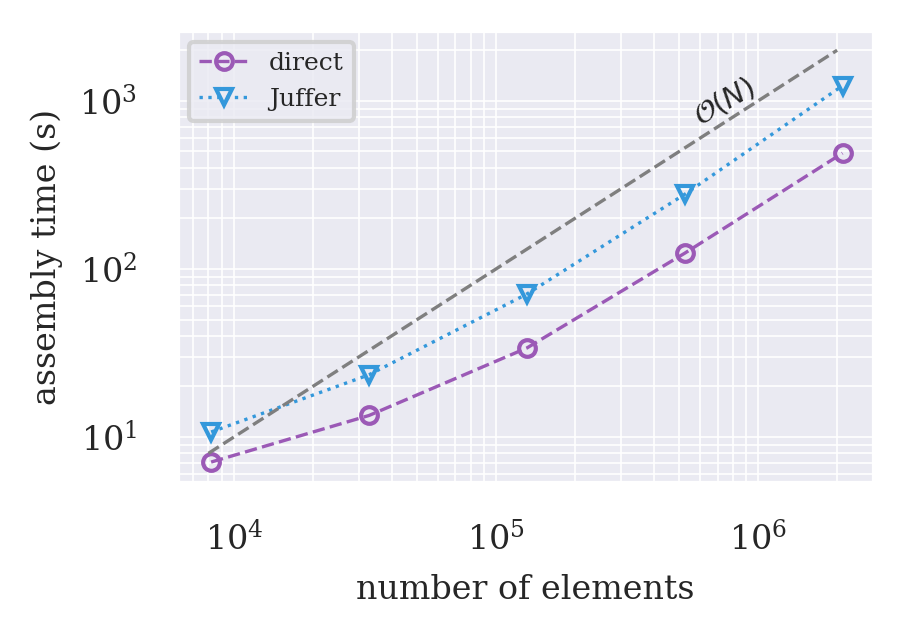

In [4]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)

ax.loglog(direct_sphere_df.index, direct_sphere_df.t_total_assembly, ls='dashed', lw=0.8, marker='o', ms=4, fillstyle='none', label='direct')
ax.loglog(juffer_sphere_df.index, juffer_sphere_df.t_total_assembly, ls='dotted', lw=0.8, marker='v', ms=4, fillstyle='none', label='Juffer')

_x = [0.8*1e4, 2e6]
_y = 100 * np.array((0.08, 20))
ax.plot(_x, _y, color='#7f7f7f', linestyle='--', linewidth=0.8)
text_loc = np.array((_x[1], _y[1]*1.2)) * 0.3
ax.text(text_loc[0], text_loc[1],r'$\mathcal{O}(N)$', fontsize=7, rotation=30,rotation_mode='anchor');

ax.set_xlabel('number of elements')
ax.set_ylabel('assembly time (s)')
ax.legend()
ax.grid(which='both', linewidth=0.4)

Next, we want to confirm that the time complexity of mat-vecs in GMRES is also $\mathcal{O}(N)$.
As we mentioned before, each iteration involves multiple FMM evaluations: 4 Laplace FMMs and 4 modified Helmholtz FMMs for direct formulation, 8 and 11 for Juffer's formulation.
We averaged the time spent on $1$ Laplace FMM and $1$ modified Helmholtz FMM respectively using direct formulation, and plot them with respect to $N$ in Figure ?.
The linear scaling substantiates the efficiency of our FMM implementation.

#### Figure: The average time of 1 Laplace FMM evaluation and 1 modified Helmholtz evaluation in GMRES with respect to problem size N using direct formulation.

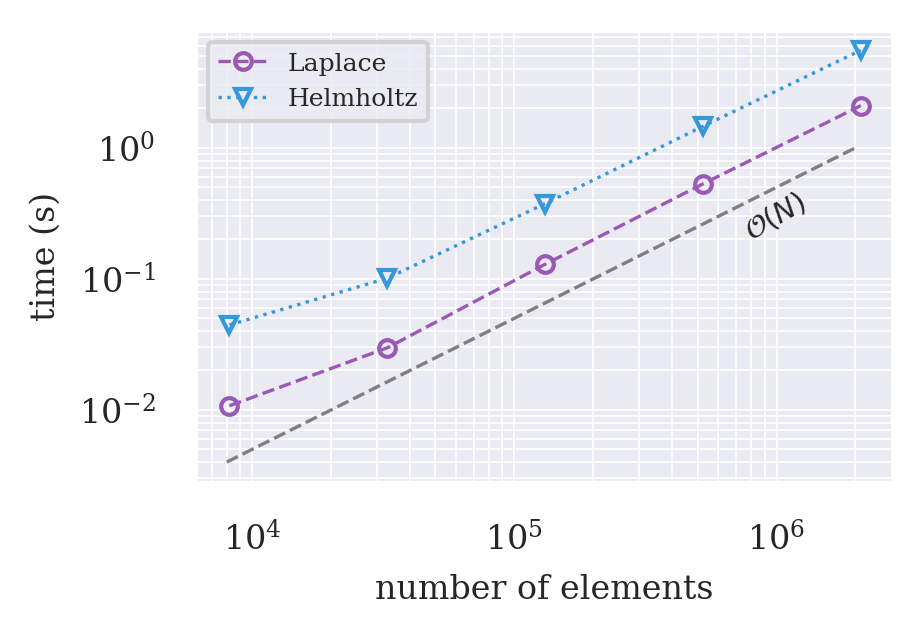

In [5]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)

ax.loglog(direct_sphere_df.index, direct_sphere_df.t_avg_laplace, ls='dashed', lw=0.8, marker='o', ms=4, fillstyle='none', label='Laplace')
ax.loglog(direct_sphere_df.index, direct_sphere_df.t_avg_helmholtz, ls='dotted', lw=0.8, marker='v', ms=4, fillstyle='none', label='Helmholtz')

_x = [0.8*1e4, 2e6]
_y = 0.05 * np.array((0.08, 20))
ax.legend(fontsize=6)
ax.plot(_x, _y, color='#7f7f7f', linestyle='--', linewidth=0.8)
text_loc = np.array((_x[1], _y[1]*0.5)) * 0.4
ax.text(text_loc[0], text_loc[1],r'$\mathcal{O}(N)$', fontsize=7, rotation=30,rotation_mode='anchor');
ax.grid(which='both', lw=0.4)
ax.set_xlabel('number of elements')
ax.set_ylabel('time (s)');

In bempp-cl, pre-computing of the invariant matrices in FMM, initializing singular assemblers and many other computations are triggered by calling the iterative solver.
In addition, each FMM evaluation in GMRES is followed by a singular correction which compensates the singular integrals that were not ignored by FMM.
Therefore, the GMRES time reported here also reflects these contributions.
Figure ? demonstrates the time breakdown of GMRES in percentage.
As problem size increases, FMM evaluations dominate solution time.

#### Figure: Time breakdown of GMRES in percentage using direct formulation (left) and Juffer's formulation (right).

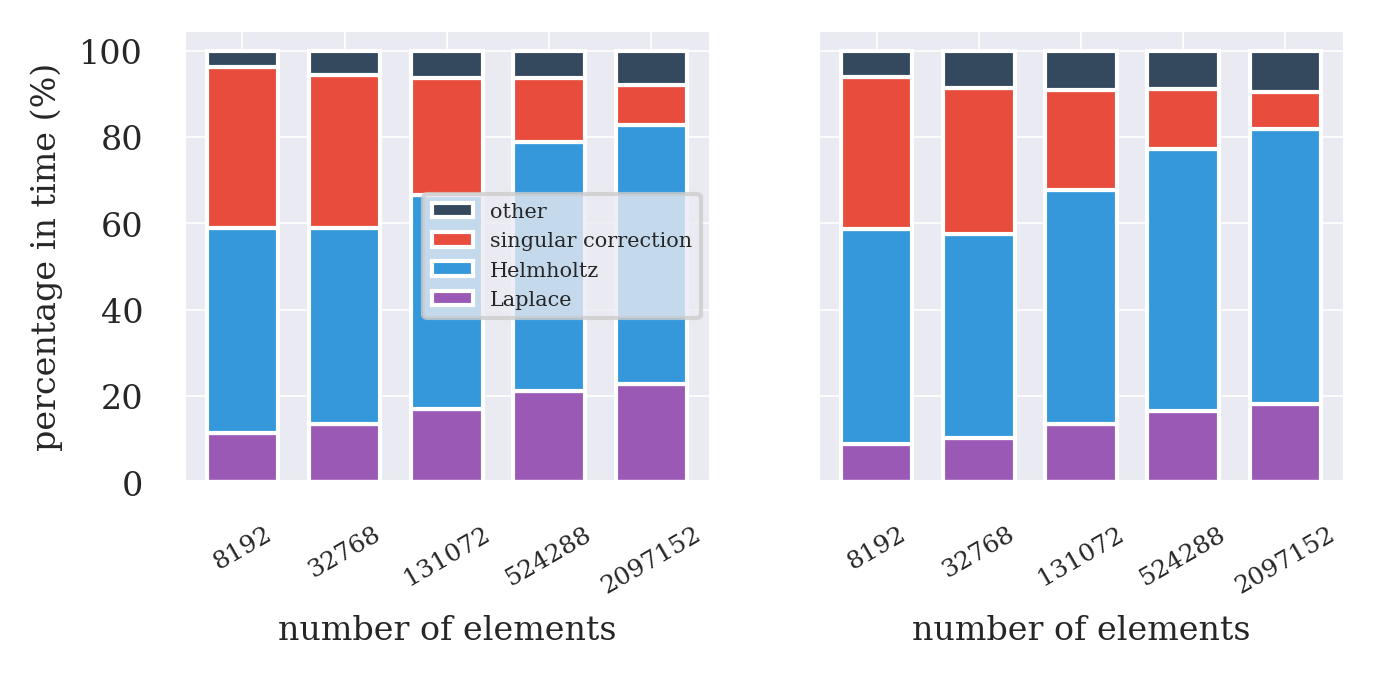

In [6]:
prop_laplace = direct_sphere_df.t_laplace / direct_sphere_df.t_total_gmres * 100
prop_helmholtz = direct_sphere_df.t_helmholtz / direct_sphere_df.t_total_gmres * 100
prop_correction = direct_sphere_df.t_singular_correction / direct_sphere_df.t_total_gmres * 100
prop_other = direct_sphere_df.t_gmres_other / direct_sphere_df.t_total_gmres * 100

width = 0.7
r = np.arange(direct_sphere_df.shape[0])
fig = plt.figure(figsize=(5,2))
ax1 = fig.add_subplot(121)

ax1.bar(r, prop_laplace, width=width, label='Laplace')
ax1.bar(r, prop_helmholtz, bottom=prop_laplace, width=width, label='Helmholtz')
ax1.bar(r, prop_correction, bottom=prop_laplace+prop_helmholtz, width=width, label='singular correction')
ax1.bar(r, prop_other, bottom=prop_laplace+prop_helmholtz+prop_correction, width=width, label='other')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], loc='best', fontsize=5)
ax1.set_xlabel('number of elements')
ax1.set_ylabel('percentage in time (%)')
ax1.grid(lw=0.4)
plt.xticks(r, direct_sphere_df.index, rotation=30, fontsize=6)

prop_laplace = juffer_sphere_df.t_laplace / juffer_sphere_df.t_total_gmres * 100
prop_helmholtz = juffer_sphere_df.t_helmholtz / juffer_sphere_df.t_total_gmres * 100
prop_correction = juffer_sphere_df.t_singular_correction / juffer_sphere_df.t_total_gmres * 100
prop_other = juffer_sphere_df.t_gmres_other / juffer_sphere_df.t_total_gmres * 100

ax2 = fig.add_subplot(122)
ax2.bar(r, prop_laplace, width=width, label='Laplace')
ax2.bar(r, prop_helmholtz, bottom=prop_laplace, width=width, label='Helmholtz')
ax2.bar(r, prop_correction, bottom=prop_laplace+prop_helmholtz, width=width, label='singular correction')
ax2.bar(r, prop_other, bottom=prop_laplace+prop_helmholtz+prop_correction, width=width, label='other')

ax2.set_xlabel('number of elements')
ax2.grid(lw=0.4)
ax2.yaxis.set_ticklabels([])
plt.xticks(r, direct_sphere_df.index, rotation=30, fontsize=6);

Finally, we measured the amount of memory taken by the simulations, using the Linux command `/usr/bin/time -v`.
We observed a linear space complexity as shown in Figure ?.
The largest case, with more than 2 million panels, requires $45$ GB for direct formulation and $65$ GB for Juffer's formulation.


#### Figure: Overall memory consumption in GB for both direct and Juffer's formulation.

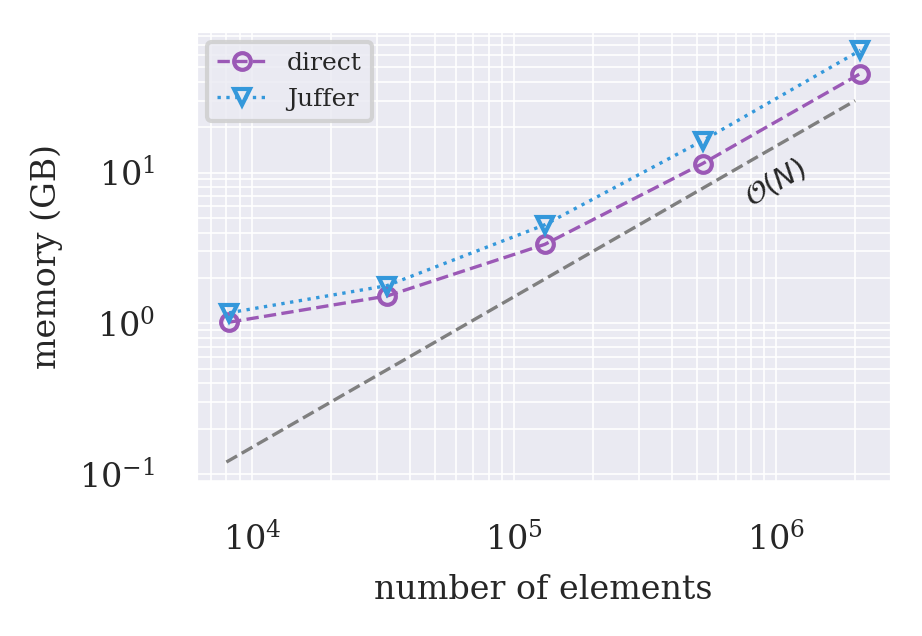

In [7]:
fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)

ax.loglog(direct_sphere_df.index, direct_sphere_df['memory [GB]'], ls='dashed', lw=0.8, ms=4, marker='o', fillstyle='none', label='direct')
ax.loglog(juffer_sphere_df.index, juffer_sphere_df['memory [GB]'], ls='dotted', lw=0.8, ms=4, marker='v', fillstyle='none', label='Juffer')
ax.grid(which='both', lw=0.4)
_x = [0.8*1e4, 2e6]
_y = 1.5 * np.array((0.08, 20))
ax.legend(fontsize=6)
ax.plot(_x, _y, color='#7f7f7f', linestyle='--', linewidth=0.8)
text_loc = np.array((_x[1], _y[1]*0.5)) * 0.4
ax.text(text_loc[0], text_loc[1],r'$\mathcal{O}(N)$', fontsize=7, rotation=30,rotation_mode='anchor');
ax.set_xlabel('number of elements')
ax.set_ylabel('memory (GB)');

--------


### Appendix

1. raw result data

In [8]:
direct_sphere_df

,t_total_assembly,t_total_gmres,num_iter,e_solv [kcal/Mol],memory [GB],t_fmm_init,t_singular_assembler,t_assemble_sparse,t_assembly_other,t_singular_correction,t_laplace,t_helmholtz,t_avg_laplace,t_avg_helmholtz,t_gmres_other
num_elem,,,,,,,,,,,,,,,
8192,7.100662,8.618167,20,-89673.355447,1.016428,1.072076,0.818286,1.771,3.439300,3.217756,0.989381,4.092878,0.010754,0.044488,0.318152
32768,13.436520,24.020062,24,-89638.782213,1.516884,1.287405,3.055460,1.726,7.367654,8.504202,3.216343,10.930223,0.029781,0.101206,1.369294
131072,33.863181,112.048321,34,-89628.742308,3.339748,3.788513,6.515974,1.934,21.624694,30.287408,19.140448,55.547432,0.129327,0.375320,7.073032
524288,124.017582,544.812424,51,-89626.526734,11.478328,14.851913,23.799833,2.275,83.090836,80.317233,114.674787,315.284018,0.530902,1.459648,34.536386
2097152,488.301116,2701.659968,70,-89626.222002,45.414884,65.245103,94.586926,3.993,324.476086,249.709707,613.219822,1623.001191,2.100068,5.558223,215.729247


In [9]:
juffer_sphere_df

,t_total_assembly,t_total_gmres,num_iter,e_solv [kcal/Mol],memory [GB],t_fmm_init,t_singular_assembler,t_assemble_sparse,t_assembly_other,t_singular_correction,t_laplace,t_helmholtz,t_avg_laplace,t_avg_helmholtz,t_gmres_other
num_elem,,,,,,,,,,,,,,,
8192,10.718557,11.652502,10,-89672.419646,1.173532,0.462746,1.196110,2.88327,6.176430,4.099680,1.043788,5.801689,0.010873,0.043952,0.707344
32768,23.463421,27.192798,10,-89636.677733,1.777100,1.119264,3.876153,3.25330,15.214704,9.226420,2.801531,12.820377,0.029183,0.097124,2.344470
131072,70.902101,91.770047,10,-89627.638433,4.505816,3.826943,8.696317,4.11590,54.262940,21.286688,12.429100,49.638525,0.129470,0.376049,8.415734
524288,277.823720,313.125447,10,-89625.100526,16.285076,14.867089,33.995573,7.54200,221.419058,43.877050,51.386974,190.320673,0.535281,1.441823,27.540751
2097152,1230.260451,1130.503977,10,-89624.077056,64.838076,63.092434,134.990487,22.03700,1010.140531,95.485813,204.496753,721.970977,2.130175,5.469477,108.550433


2. Time breakdown of system matrix assembly

In [10]:
cols_assembly = ['t_total_assembly', 't_singular_assembler', 't_assemble_sparse', 't_assembly_other']

In [11]:
direct_sphere_df[cols_assembly]

,t_total_assembly,t_singular_assembler,t_assemble_sparse,t_assembly_other
num_elem,,,,
8192,7.100662,0.818286,1.771,3.439300
32768,13.436520,3.055460,1.726,7.367654
131072,33.863181,6.515974,1.934,21.624694
524288,124.017582,23.799833,2.275,83.090836
2097152,488.301116,94.586926,3.993,324.476086


In [12]:
juffer_sphere_df[cols_assembly]

,t_total_assembly,t_singular_assembler,t_assemble_sparse,t_assembly_other
num_elem,,,,
8192,10.718557,1.196110,2.88327,6.176430
32768,23.463421,3.876153,3.25330,15.214704
131072,70.902101,8.696317,4.11590,54.262940
524288,277.823720,33.995573,7.54200,221.419058
2097152,1230.260451,134.990487,22.03700,1010.140531
